In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.4.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.4.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
#maxEvents = 10000
#maxEvents = 200000
maxEvents = 2000000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)
nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def delta_phi(lhs, rhs):  # in radians
  rad = lhs - rhs
  while rad <  -np.pi:  rad += np.pi*2
  while rad >= +np.pi:  rad -= np.pi*2
  return rad

def delta_theta(lhs, rhs):  # in radians
  rad = lhs - rhs
  return rad

def range_phi_deg(deg):
  while deg <  -180.:
    deg += 360.
  while deg >= +180.:
    deg -= 360.
  return deg

def calc_phi_loc_deg_from_glob(glob, sector):
  # glob in deg, sector [1-6]
  glob = range_phi_deg(glob)
  loc = glob - 15. - (60. * (sector-1))
  return loc

def calc_phi_loc_int(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  phi_int = int(round(loc))
  return phi_int

def calc_phi_loc_int_1(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  #phi_int = int(round(loc))
  phi_int = loc  # no cast to int
  return phi_int

def calc_theta_int(theta, endcap):
  # theta in deg, endcap [-1,+1]
  if endcap == -1:
    theta = 180. - theta
  theta = (theta - 8.5) * 128./(45.0-8.5)
  theta_int = int(round(theta))
  return theta_int

In [5]:
# Collect hits in ME1/1a, or ME1/1b, or ME1/2 from events 
# where the hits exist in the same sector, but different F/R.
# Calculate the difference in the integer phi unit and 
# the correction to the common plane use the bend.

class Collector(object):
  def __init__(self, select_fn, select_fn_2):
    self.select_fn = select_fn
    self.select_fn_2 = select_fn_2
  
  def run(self, hits):
    cached_hits = []
    found_f = False
    found_r = False
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        if hit.fr == 1:
          found_f = True
        elif hit.fr == 0:
          found_r = True
        else:
          raise Exception('Expect only F or R')
        cached_hits.append(hit)
    
    found_same_sector = (len(set([hit.sector for hit in cached_hits])) == 1)
    found_fr_pair = (len(cached_hits) == 2)
    
    hit_f = None
    hit_r = None
    
    if found_f and found_r and found_same_sector and found_fr_pair:
      for ihit, hit in enumerate(cached_hits):
        hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
        hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
        if abs(int(round(hit.fph)) - hit.emtf_phi) > 7*2:  # check 1
          s = '{0}, {1}'.format(int(round(hit.fph)), hit.emtf_phi)
          raise Exception('Expect at most +/-7 correction, but: ' + s)

        if hit.fr == 1:
          hit_f = hit
        elif hit.fr == 0:
          hit_r = hit
        else:
          raise Exception('Expect only F or R')

      assert(hit_f is not None)
      assert(hit_r is not None)
      if abs(hit_r.chamber - hit_f.chamber) != 1 and abs(hit_r.chamber - hit_f.chamber) != (36-1):
        s = '{0}, {1}'.format(hit_r.chamber, hit_f.chamber)
        raise Exception('Expect chamber differ by 1, but: ' + s)

      return (0.5*(hit_r.fph - hit_f.fph), (hit_r.bend * hit_r.endcap), (hit_f.bend * hit_f.endcap))
    return (np.inf, np.inf, np.inf)

In [6]:
class GEMFinder(object):
  def __init__(self, select_fn, select_fn_2, select_fn_gem):
    self.select_fn = select_fn
    self.select_fn_2 = select_fn_2
    self.select_fn_gem = select_fn_gem
    
  def run(self, hits):
    cached_hits = []
    for ihit, hit in enumerate(hits):
      if self.select_fn(hit) and self.select_fn_2(hit):
        cached_hits.append(hit)
    
    cached_hits_gem = []
    for ihit, hit in enumerate(hits):
      if self.select_fn_gem(hit) and self.select_fn_2(hit):
        cached_hits_gem.append(hit)
    
    hit_csc = None
    if cached_hits:
      hit_phis = [hit.emtf_phi for hit in cached_hits]
      if (np.max(hit_phis) - np.min(hit_phis)) < 8*4:
        hit_csc = np.random.choice(cached_hits)
    
    hit_gem = None
    if cached_hits_gem:
      hit_phis = [hit.emtf_phi for hit in cached_hits_gem]
      if (np.max(hit_phis) - np.min(hit_phis)) < 8*4:
        hit_gem = np.random.choice(cached_hits_gem)
    return (hit_csc, hit_gem)

In [7]:
def process(verbose=1):
  tree = load_pgun()
  
  outs_me11a = []
  outs_me11b = []
  outs_me12 = []
  outs_gem_me11a = []
  outs_gem_me11b = []
  outs_gem_me12 = []
  
  select_fn_me11a = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 4)
  select_fn_me11b = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 1)
  select_fn_me12 = lambda hit: (hit.type == kCSC and hit.station == 1 and hit.ring == 2)
  select_fn_ge11 = lambda hit: (hit.type == kGEM and hit.station == 1 and hit.ring == 1)
  
  #select_fn_2 = lambda hit: (hit.neighbor == 0 and hit.bx == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0)
  select_fn_2 = lambda hit: (hit.neighbor == 0 and hit.sim_tp1 == 0 and hit.sim_tp2 == 0)
  
  collector_me11a = Collector(select_fn_me11a, select_fn_2)
  collector_me11b = Collector(select_fn_me11b, select_fn_2)
  collector_me12 = Collector(select_fn_me12, select_fn_2)
  
  gemfinder_me11a = GEMFinder(select_fn_me11a, select_fn_2, select_fn_ge11)
  gemfinder_me11b = GEMFinder(select_fn_me11b, select_fn_2, select_fn_ge11)
  gemfinder_me12 = GEMFinder(select_fn_me12, select_fn_2, select_fn_ge11)

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
      
    # Skip events with pT < 3 GeV
    if evt.particles[0].pt < 3:
      continue

    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    if verbose and ievt < 20:
      print("evt {0} has {1} particles and {2} hits".format(ievt, len(evt.particles), len(evt.hits)))
      for ihit, hit in enumerate(evt.hits):
        hit.fph = calc_phi_loc_int_1(hit.sim_phi, hit.sector)
        hit.th = calc_theta_int(hit.sim_theta, hit.endcap)
        if abs(int(round(hit.fph)) - hit.emtf_phi) > 7*2:  # check 2
          s = '{0}, {1}'.format(int(round(hit.fph)), hit.emtf_phi)
          raise Exception('Expect at most +/-7 correction, but: ' + s)
        print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12} {13}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2, hit.emtf_phi, hit.fph))
    
    (rf, bend_r, bend_f) = collector_me11a.run(evt.hits)
    if np.isfinite(rf):
      outs_me11a.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me11b.run(evt.hits)
    if np.isfinite(rf):
      outs_me11b.append((part.invpt, rf, bend_r, bend_f))
    
    (rf, bend_r, bend_f) = collector_me12.run(evt.hits)
    if np.isfinite(rf):
      outs_me12.append((part.invpt, rf, bend_r, bend_f))
    
    if 1.55 <= abs(part.eta) <= 2.15:
      (hit_csc, hit_gem) = gemfinder_me11a.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me11a.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

      (hit_csc, hit_gem) = gemfinder_me11b.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me11b.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

      (hit_csc, hit_gem) = gemfinder_me12.run(evt.hits)
      if (hit_csc is not None) and (hit_gem is not None):
        outs_gem_me12.append((part.invpt, hit_csc.fr, hit_csc.endcap, hit_csc.pattern, hit_csc.emtf_phi, hit_csc.bend, hit_gem.emtf_phi, hit_gem.bend))

  return (np.asarray(outs_me11a), np.asarray(outs_me11b), np.asarray(outs_me12), 
          np.asarray(outs_gem_me11a), np.asarray(outs_gem_me11b), np.asarray(outs_gem_me12))

In [8]:
outs_me11a, outs_me11b, outs_me12, outs_gem_me11a, outs_gem_me11b, outs_gem_me12 = process()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Endcap_2GeV_add.4.root
Processing event: 0
evt 0 has 1 particles and 18 hits
.. hit  0 0 3 1 1 3 1 -173.703933716 21.4738960266 0 0 0 4398 4397.76397705
.. hit  1 0 3 2 1 3 1 -167.562713623 21.4324035645 0 0 0 4766 4766.23718262
.. hit  2 0 1 1 1 3 1 -173.017547607 21.9236450195 0 0 0 4438 4438.94714355
.. hit  3 0 2 1 2 3 1 -169.529083252 24.5178012848 3 0 0 4648 4648.25500488
.. hit  4 0 1 2 1 3 1 -167.39944458 21.6250953674 0 0 0 4778 4776.0333252
.. hit  5 0 2 3 2 3 0 -167.495315552 22.8026676178 1 0 0 4772 4770.28106689
.. hit  6 0 1 4 2 3 0 -167.668045044 21.1594657898 0 0 0 4762 4759.91729736
.. hit  7 0 1 4 2 3 0 -167.668060303 20.4271774292 0 0 0 4762 4759.91638184
.. hit  8 0 2 4 2 3 0 -167.651672363 21.0329170227 -1 0 0 4760 4760.8996582
.. hit  9 0 3 1 1 4 1 -173.703933716 21.4738960266 0 0 0 798 797.763977051
.. hit  10 0 3 2 1 4 1 -167.562713623 21.4324035645 0 0 0 1166 1166.23718262
.. hit  11 0 1 1 1 4 1 -173.017547607 21.

Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processing event: 39000
Processing event: 40000
Processing event: 41000
Processing event: 42000
P

Processing event: 334000
Processing event: 335000
Processing event: 336000
Processing event: 337000
Processing event: 338000
Processing event: 339000
Processing event: 340000
Processing event: 341000
Processing event: 342000
Processing event: 343000
Processing event: 344000
Processing event: 345000
Processing event: 346000
Processing event: 347000
Processing event: 348000
Processing event: 349000
Processing event: 350000
Processing event: 351000
Processing event: 352000
Processing event: 353000
Processing event: 354000
Processing event: 355000
Processing event: 356000
Processing event: 357000
Processing event: 358000
Processing event: 359000
Processing event: 360000
Processing event: 361000
Processing event: 362000
Processing event: 363000
Processing event: 364000
Processing event: 365000
Processing event: 366000
Processing event: 367000
Processing event: 368000
Processing event: 369000
Processing event: 370000
Processing event: 371000
Processing event: 372000
Processing event: 373000


Processing event: 662000
Processing event: 663000
Processing event: 664000
Processing event: 665000
Processing event: 666000
Processing event: 667000
Processing event: 668000
Processing event: 669000
Processing event: 670000
Processing event: 671000
Processing event: 672000
Processing event: 673000
Processing event: 674000
Processing event: 675000
Processing event: 676000
Processing event: 677000
Processing event: 678000
Processing event: 679000
Processing event: 680000
Processing event: 681000
Processing event: 682000
Processing event: 683000
Processing event: 684000
Processing event: 685000
Processing event: 686000
Processing event: 687000
Processing event: 688000
Processing event: 689000
Processing event: 690000
Processing event: 691000
Processing event: 692000
Processing event: 693000
Processing event: 694000
Processing event: 695000
Processing event: 696000
Processing event: 697000
Processing event: 698000
Processing event: 699000
Processing event: 700000
Processing event: 701000


Processing event: 990000
Processing event: 991000
Processing event: 992000
Processing event: 993000
Processing event: 994000
Processing event: 995000
Processing event: 996000
Processing event: 997000
Processing event: 998000
Processing event: 999000
Processing event: 1000000
Processing event: 1001000
Processing event: 1002000
Processing event: 1003000
Processing event: 1004000
Processing event: 1005000
Processing event: 1006000
Processing event: 1007000
Processing event: 1008000
Processing event: 1009000
Processing event: 1010000
Processing event: 1011000
Processing event: 1012000
Processing event: 1013000
Processing event: 1014000
Processing event: 1015000
Processing event: 1016000
Processing event: 1017000
Processing event: 1018000
Processing event: 1019000
Processing event: 1020000
Processing event: 1021000
Processing event: 1022000
Processing event: 1023000
Processing event: 1024000
Processing event: 1025000
Processing event: 1026000
Processing event: 1027000
Processing event: 1028

Processing event: 1306000
Processing event: 1307000
Processing event: 1308000
Processing event: 1309000
Processing event: 1310000
Processing event: 1311000
Processing event: 1312000
Processing event: 1313000
Processing event: 1314000
Processing event: 1315000
Processing event: 1316000
Processing event: 1317000
Processing event: 1318000
Processing event: 1319000
Processing event: 1320000
Processing event: 1321000
Processing event: 1322000
Processing event: 1323000
Processing event: 1324000
Processing event: 1325000
Processing event: 1326000
Processing event: 1327000
Processing event: 1328000
Processing event: 1329000
Processing event: 1330000
Processing event: 1331000
Processing event: 1332000
Processing event: 1333000
Processing event: 1334000
Processing event: 1335000
Processing event: 1336000
Processing event: 1337000
Processing event: 1338000
Processing event: 1339000
Processing event: 1340000
Processing event: 1341000
Processing event: 1342000
Processing event: 1343000
Processing e

Processing event: 1622000
Processing event: 1623000
Processing event: 1624000
Processing event: 1625000
Processing event: 1626000
Processing event: 1627000
Processing event: 1628000
Processing event: 1629000
Processing event: 1630000
Processing event: 1631000
Processing event: 1632000
Processing event: 1633000
Processing event: 1634000
Processing event: 1635000
Processing event: 1636000
Processing event: 1637000
Processing event: 1638000
Processing event: 1639000
Processing event: 1640000
Processing event: 1641000
Processing event: 1642000
Processing event: 1643000
Processing event: 1644000
Processing event: 1645000
Processing event: 1646000
Processing event: 1647000
Processing event: 1648000
Processing event: 1649000
Processing event: 1650000
Processing event: 1651000
Processing event: 1652000
Processing event: 1653000
Processing event: 1654000
Processing event: 1655000
Processing event: 1656000
Processing event: 1657000
Processing event: 1658000
Processing event: 1659000
Processing e

Processing event: 1938000
Processing event: 1939000
Processing event: 1940000
Processing event: 1941000
Processing event: 1942000
Processing event: 1943000
Processing event: 1944000
Processing event: 1945000
Processing event: 1946000
Processing event: 1947000
Processing event: 1948000
Processing event: 1949000
Processing event: 1950000
Processing event: 1951000
Processing event: 1952000
Processing event: 1953000
Processing event: 1954000
Processing event: 1955000
Processing event: 1956000
Processing event: 1957000
Processing event: 1958000
Processing event: 1959000
Processing event: 1960000
Processing event: 1961000
Processing event: 1962000
Processing event: 1963000
Processing event: 1964000
Processing event: 1965000
Processing event: 1966000
Processing event: 1967000
Processing event: 1968000
Processing event: 1969000
Processing event: 1970000
Processing event: 1971000
Processing event: 1972000
Processing event: 1973000
Processing event: 1974000
Processing event: 1975000
Processing e

In [9]:
print outs_me11a.shape, outs_me11b.shape, outs_me12.shape, outs_gem_me11a.shape, outs_gem_me11b.shape, outs_gem_me12.shape

(4231, 4) (14677, 4) (11460, 4) (55351, 8) (465120, 8) (37192, 8)


In [10]:
# Save

outfile = 'frontrear_out.npz'
np.savez_compressed(outfile, outs_me11a=outs_me11a, outs_me11b=outs_me11b, outs_me12=outs_me12, outs_gem_me11a=outs_gem_me11a, outs_gem_me11b=outs_gem_me11b, outs_gem_me12=outs_gem_me12)

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Liberation Sans (u'/usr/share/fonts/liberation/LiberationSans-Regular.ttf') with score of 4.050000


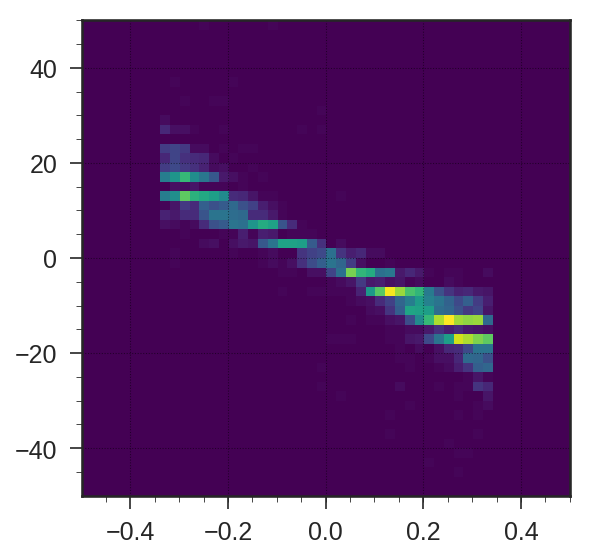

In [12]:
# Results

x = outs_me11a[:,0]  # q/pt
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-0.5,0.5),(-50,50)))
plt.show()

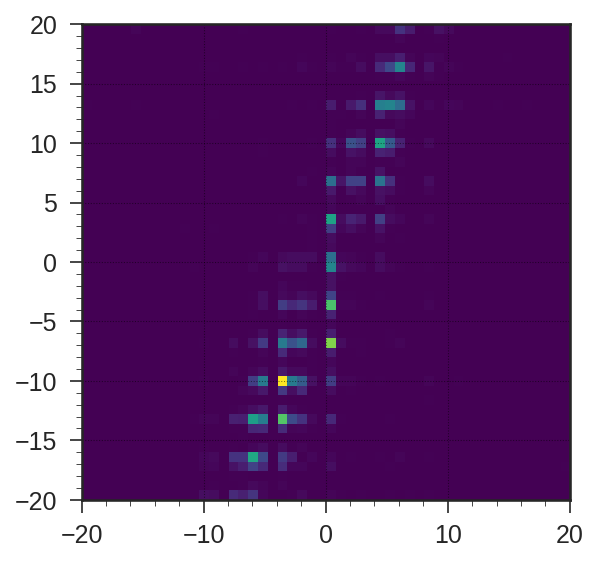

In [13]:
x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

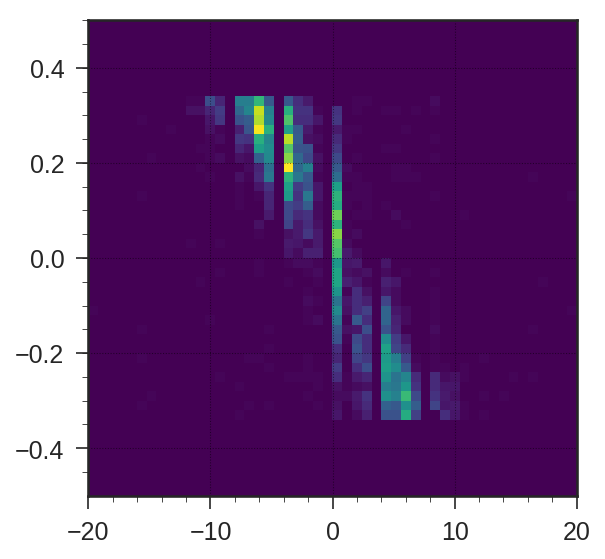

In [14]:
x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,0]  # q/pt

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

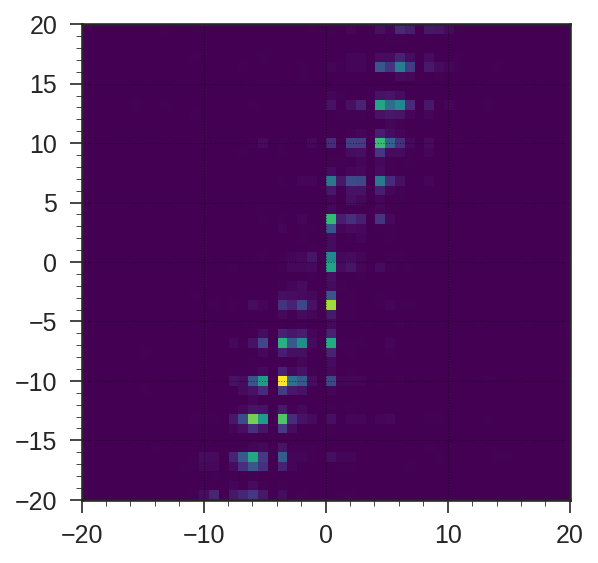

In [15]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,1]  # dist = 0.5(r-f)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
plt.show()

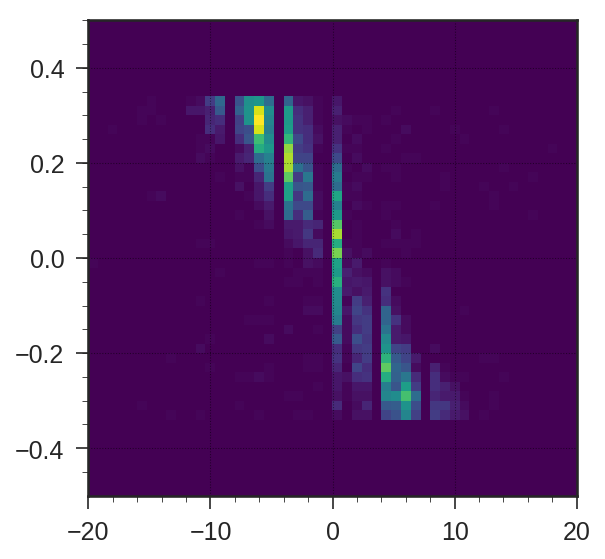

In [16]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,0]  # q/pt

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-0.5,0.5)))
plt.show()

0.0 [2.20600083]
0.0 [2.46400055]


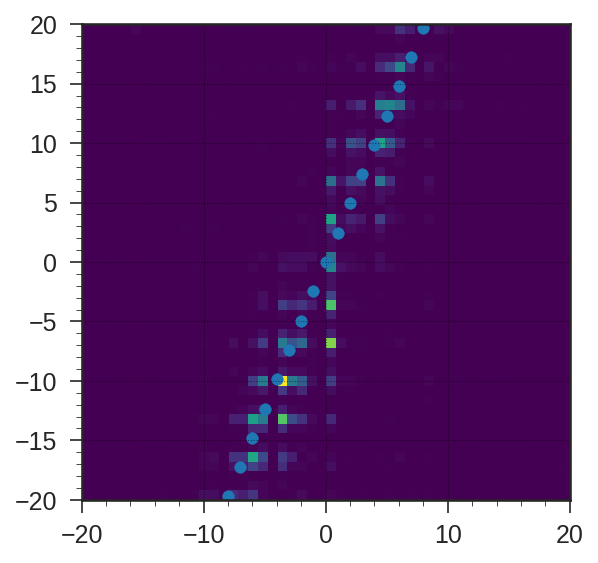

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor

x = outs_me11a[:,2]  # bend_r
y = outs_me11a[:,1]  # dist = 0.5(r-f)

rid = Ridge(fit_intercept=False,alpha=0.1)
rid.fit(np.atleast_2d(x).T, y)
huber = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
huber.fit(np.atleast_2d(x).T, y)
print rid.intercept_, rid.coef_
print huber.intercept_, huber.coef_

xx = np.linspace(-20,20,num=41)
yy = huber.predict(np.atleast_2d(xx).T)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
ax.scatter(xx, yy)
plt.show()

0.0 [2.05436793]
0.0 [2.38864882]


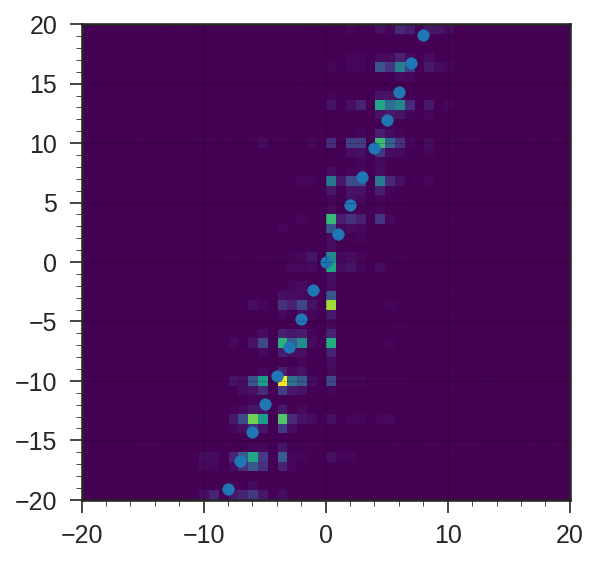

In [18]:
x = outs_me11a[:,3]  # bend_f
y = outs_me11a[:,1]  # dist = 0.5(r-f)

rid = Ridge(fit_intercept=False,alpha=0.1)
rid.fit(np.atleast_2d(x).T, y)
huber = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
huber.fit(np.atleast_2d(x).T, y)
print rid.intercept_, rid.coef_
print huber.intercept_, huber.coef_

xx = np.linspace(-20,20,num=41)
yy = huber.predict(np.atleast_2d(xx).T)

fig, ax = plt.subplots()
ax.hist2d(x, y, bins=(50,50), range=((-20,20),(-20,20)))
ax.scatter(xx, yy)
plt.show()

In [19]:
def doit():
  for x, y, label in xy:
    print label
    lin = LinearRegression(fit_intercept=False)
    lin.fit(np.atleast_2d(x).T, y)
    print lin.intercept_, lin.coef_
    rid1 = Ridge(fit_intercept=False,alpha=1)
    rid1.fit(np.atleast_2d(x).T, y)
    print rid1.intercept_, rid1.coef_
    rid2 = Ridge(fit_intercept=False,alpha=0.1)
    rid2.fit(np.atleast_2d(x).T, y)
    print rid2.intercept_, rid2.coef_
    rid3 = Ridge(fit_intercept=False,alpha=0.01)
    rid3.fit(np.atleast_2d(x).T, y)
    print rid3.intercept_, rid3.coef_
    huber1 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.35)
    huber1.fit(np.atleast_2d(x).T, y)
    print huber1.intercept_, huber1.coef_
    huber2 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=1.5)
    huber2.fit(np.atleast_2d(x).T, y)
    print huber2.intercept_, huber2.coef_
    huber3 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=2.0)
    huber3.fit(np.atleast_2d(x).T, y)
    print huber3.intercept_, huber3.coef_
    huber4 = HuberRegressor(fit_intercept=False, alpha=0.0001, max_iter=30, epsilon=3.0)
    huber4.fit(np.atleast_2d(x).T, y)
    print huber4.intercept_, huber4.coef_

In [20]:
# ME1/1b
xy = [
  (outs_me11b[:,2], outs_me11b[:,1], 'x: bend_r, y: dist'),
  (outs_me11b[:,3], outs_me11b[:,1], 'x: bend_f, y: dist'),
  #(outs_me11b[:,2], outs_me11b[:,0], 'x: bend_r, y: q/pt'),
  #(outs_me11b[:,3], outs_me11b[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [2.04105863]
0.0 [2.04105705]
0.0 [2.04105848]
0.0 [2.04105862]
0.0 [2.08326548]
0.0 [2.08249072]
0.0 [2.07866253]
0.0 [2.07091535]
x: bend_f, y: dist
0.0 [1.9704339]
0.0 [1.9704324]
0.0 [1.97043375]
0.0 [1.97043389]
0.0 [2.04972418]
0.0 [2.04852249]
0.0 [2.04472723]
0.0 [2.03429906]


In [21]:
# ME1/1a
xy = [
  (outs_me11a[:,2], outs_me11a[:,1], 'x: bend_r, y: dist'),
  (outs_me11a[:,3], outs_me11a[:,1], 'x: bend_f, y: dist'),
  #(outs_me11a[:,2], outs_me11a[:,0], 'x: bend_r, y: q/pt'),
  #(outs_me11a[:,3], outs_me11a[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [2.20600309]
0.0 [2.20598053]
0.0 [2.20600083]
0.0 [2.20600286]
0.0 [2.46400055]
0.0 [2.45128821]
0.0 [2.4143761]
0.0 [2.35398535]
x: bend_f, y: dist
0.0 [2.05436991]
0.0 [2.05435011]
0.0 [2.05436793]
0.0 [2.05436972]
0.0 [2.38864882]
0.0 [2.37869412]
0.0 [2.34672625]
0.0 [2.28074129]


In [22]:
# ME1/2
xy = [
  (outs_me12[:,2], outs_me12[:,1], 'x: bend_r, y: dist'),
  (outs_me12[:,3], outs_me12[:,1], 'x: bend_f, y: dist'),
  #(outs_me12[:,2], outs_me12[:,0], 'x: bend_r, y: q/pt'),
  #(outs_me12[:,3], outs_me12[:,0], 'x: bend_f, y: q/pt'),
]

doit()

x: bend_r, y: dist
0.0 [1.36303846]
0.0 [1.36303734]
0.0 [1.36303834]
0.0 [1.36303844]
0.0 [1.3774156]
0.0 [1.37719249]
0.0 [1.37588687]
0.0 [1.3733757]
x: bend_f, y: dist
0.0 [1.22890393]
0.0 [1.22890311]
0.0 [1.22890385]
0.0 [1.22890392]
0.0 [1.24476887]
0.0 [1.24405869]
0.0 [1.24205525]
0.0 [1.23964728]


In [23]:
def doit():
  data_5GeV_r = []
  data_5GeV_f = []
  data_20GeV_r = []
  data_20GeV_f = []

  xscale = (1./60) * (np.pi/180)

  for (invpt, fr, endcap, pattern, csc_phi, csc_bend, gem_phi, gem_bend) in gems:
    if apply_correction:
      ## Remove patt_corr
      #ph_pattern_corr = [0, 0, 5, 5, 5, 5, 2, 2, 2, 2, 0]
      #ph_pattern_corr_sign = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
      #patt_corr = ph_pattern_corr[int(pattern)]
      #patt_corr_sign = ph_pattern_corr_sign[int(pattern)]
      #patt_corr_sign = 1 if patt_corr_sign == 0 else -1
      #patt_corr_sign = patt_corr_sign if endcap == 1 else (patt_corr_sign * -1)
      #patt_corr = (patt_corr >> 1)  # 10 degree
      #patt_corr = patt_corr * patt_corr_const
      #csc_phi = csc_phi - (patt_corr * patt_corr_sign)

      # Add bend_corr
      bend_corr = bend_corr_const[int(fr)] * csc_bend
      bend_corr = bend_corr if endcap == 1 else (bend_corr * -1)
      bend_corr = int(round(bend_corr))
      csc_phi = csc_phi + bend_corr

      # Integer
      csc_phi = round(csc_phi)
    
    # GEM-CSC angle
    pt = np.abs(1.0/invpt)
    q = np.sign(invpt)
    dphi = (gem_phi - csc_phi) * q
    if dphi < 1800.:
      dphi += 3600.
    if dphi >= 1800.:
      dphi -= 3600.
    dphi = int(dphi)
    dphi *= xscale

    if (5 <= pt <= 10):
      if fr == 0:
        data_5GeV_r.append(dphi)
      else:
        data_5GeV_f.append(dphi)
    elif (20 <= pt <= 40):
      if fr == 0:
        data_20GeV_r.append(dphi)
      else:
        data_20GeV_f.append(dphi)
  return np.asarray(data_5GeV_r), np.asarray(data_5GeV_f), np.asarray(data_20GeV_r), np.asarray(data_20GeV_f)

### ME1/1b

In [24]:
apply_correction = False
gems = outs_gem_me11b
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(72444,) (71355,) (17850,) (17705,)
0.01095539185034712 0.005011169552192122 0.002583217663017116 0.0011787338967813347


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


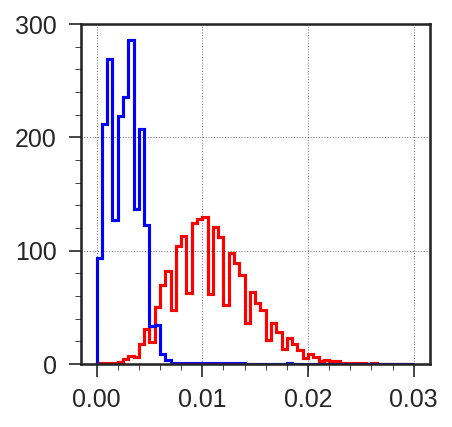

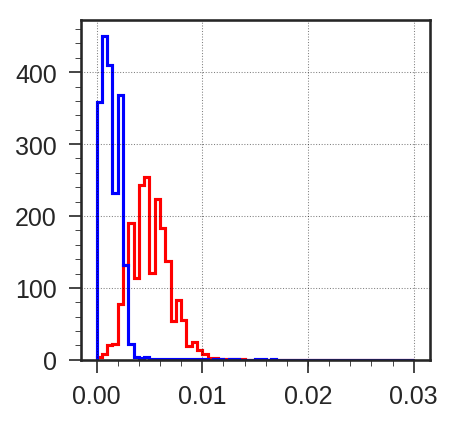

In [25]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='r')
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='b')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='r')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=60, range=(0,0.03), histtype='step', linewidth=1.5, color='b')
plt.show()

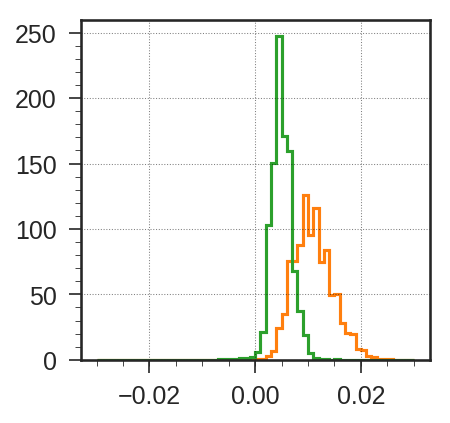

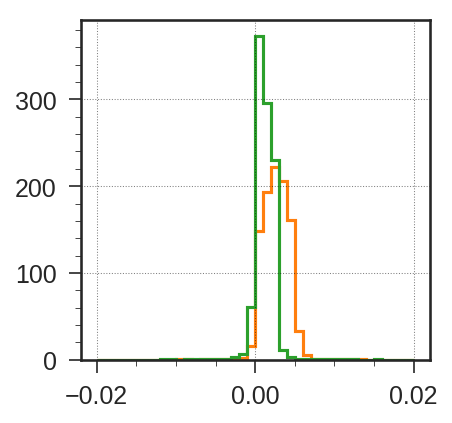

In [26]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [27]:
apply_correction = True
gems = outs_gem_me11b
patt_corr_const = (1301. / 1024.)  # ME1/1b
bend_corr_const = [-2.0832, 2.0497]  # ME1/1b (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(72444,) (71355,) (17850,) (17705,)
0.00783279261794653 0.008296634767763988 0.0018898770621268198 0.001946823349202825


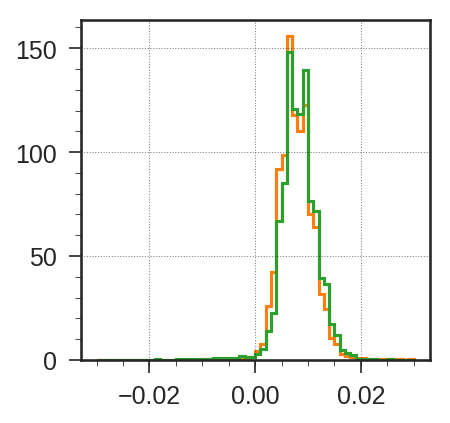

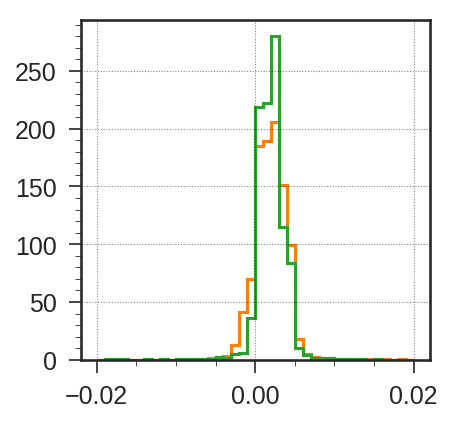

In [28]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

### ME1/1a

In [29]:
apply_correction = False
gems = outs_gem_me11a
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(4761,) (11699,) (1154,) (2831,)
0.007845366797296922 0.003461219095572537 0.0019444641608729431 0.0007873812585677939


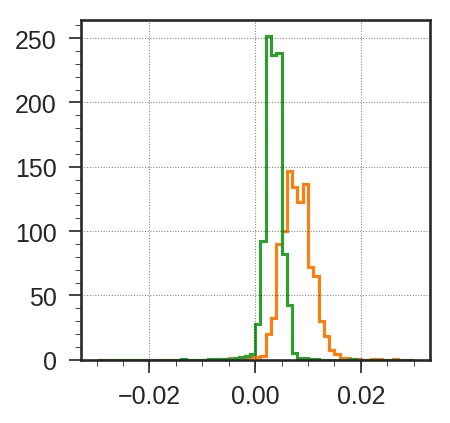

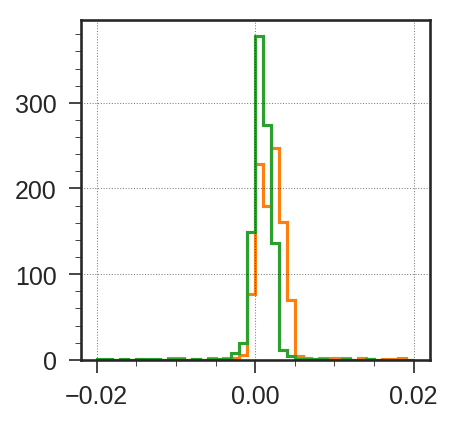

In [30]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [31]:
apply_correction = True
gems = outs_gem_me11a
patt_corr_const = (1707. / 1024.)  # ME1/1a
bend_corr_const = [-2.4640, 2.3886]  # ME1/1a (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(4761,) (11699,) (1154,) (2831,)
0.00594289314860269 0.005587694201967828 0.001548967107669722 0.0012865458356423527


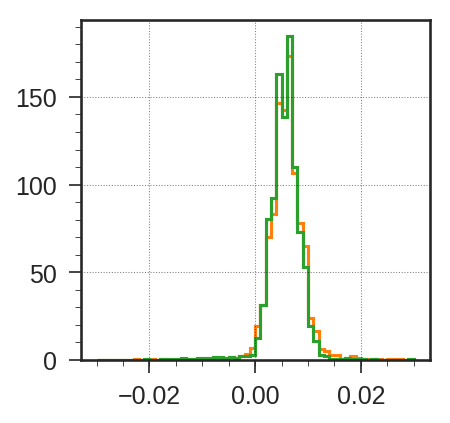

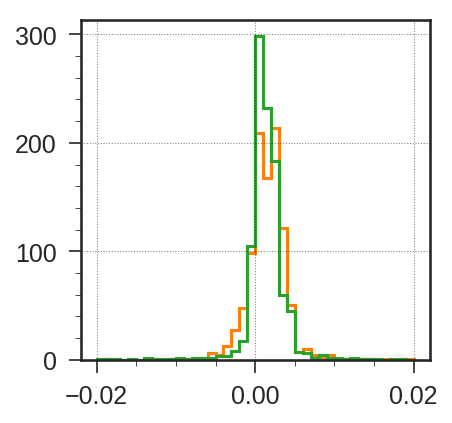

In [32]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(-0.03,0.03), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(-0.02,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

### ME1/2

In [33]:
apply_correction = False
gems = outs_gem_me12
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(6704,) (6010,) (1506,) (2086,)
0.04161588859617455 0.034406170199721045 0.009403067579193 0.008254336402468868


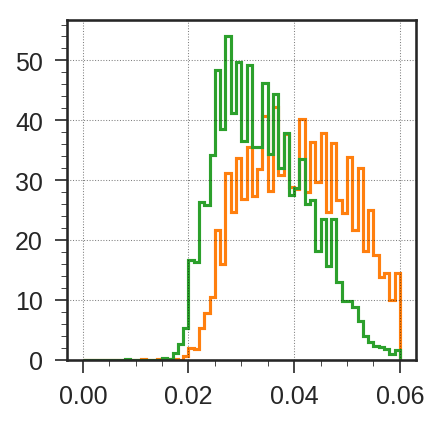

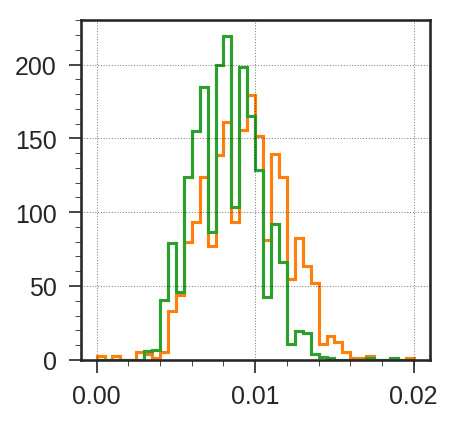

In [34]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()

In [35]:
apply_correction = True
gems = outs_gem_me12
patt_corr_const = (1024. / 1024.)  # ME1/2
bend_corr_const = [-1.3774, 1.2447]  # ME1/2 (r,f)
data_5GeV_r, data_5GeV_f, data_20GeV_r, data_20GeV_f = doit()

print data_5GeV_r.shape, data_5GeV_f.shape, data_20GeV_r.shape, data_20GeV_f.shape
print np.mean(data_5GeV_r), np.mean(data_5GeV_f), np.mean(data_20GeV_r), np.mean(data_20GeV_f)

(6704,) (6010,) (1506,) (2086,)
0.038372858225666696 0.037483438322642504 0.008671018236003702 0.00896301036049341


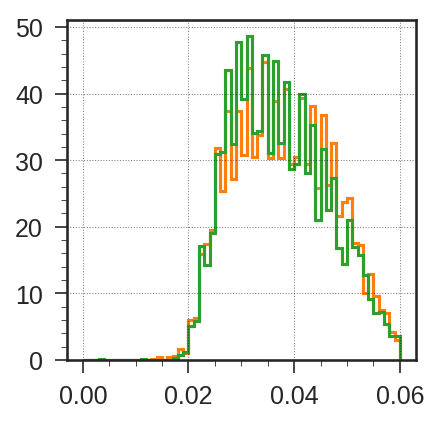

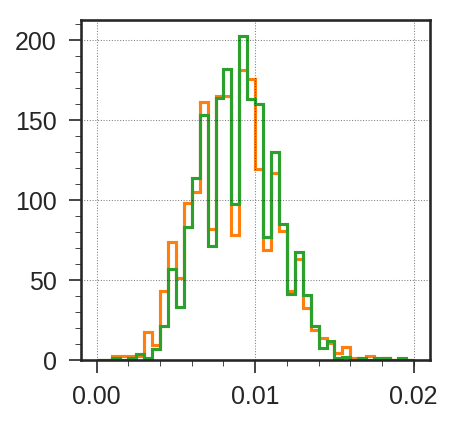

In [36]:
fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_5GeV_r, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_5GeV_f, normed=True, bins=60, range=(0,0.06), histtype='step', linewidth=1.5, color='#2ca02c')

fig, ax = plt.subplots(figsize=(3.0,3.0))
hist, edges, _ = ax.hist(data_20GeV_r, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#ff7f0e')
hist, edges, _ = ax.hist(data_20GeV_f, normed=True, bins=40, range=(0,0.02), histtype='step', linewidth=1.5, color='#2ca02c')
plt.show()